# 0) Import des Librairies

---



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [2]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

C:\Users\edmee\AppData\Local\Temp\ipykernel_12840\4139613647.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)


# 1) Import des données

In [7]:
stations = pd.read_csv('./Data/donnees_stations_hydrometrie.csv')
sites = pd.read_csv('./Data/donnees_sites_hydrometrie.csv')
donne_hydro1 = pd.read_csv('./Data/donnees_hydrometrie.csv',  low_memory=False)
donne_hydro2=pd.read_csv('./Data/donnees_hydrometrie_2.csv',  low_memory=False)

# donne_meteo = pd.read_csv('/content/donnees_meteo_2020-2023.csv')

In [43]:
data=donne_hydro1[:]

In [9]:
print(len(data[["date_obs_elab", "code_station"]].drop_duplicates()))
len(data[["code_site","code_station"]])

3256000


3256000

# 2) Traitement des données

#### 2.1) Variables intéressantes

In [10]:
data["libelle_qualification"].unique()

array(['Bonne', 'Douteuse', 'Non qualifiée'], dtype=object)

Variables qui me semblent interressantes

In [11]:
data.columns

Index(['code_site', 'code_station', 'date_obs_elab', 'resultat_obs_elab',
       'date_prod', 'code_statut', 'libelle_statut', 'code_methode',
       'libelle_methode', 'code_qualification', 'libelle_qualification',
       'longitude', 'latitude', 'grandeur_hydro_elab'],
      dtype='object')

In [39]:
stations.columns

Index(['code_site', 'libelle_site', 'code_station', 'libelle_station',
       'type_station', 'coordonnee_x_station', 'coordonnee_y_station',
       'code_projection', 'longitude_station', 'latitude_station',
       'influence_locale_station', 'commentaire_station',
       'altitude_ref_alti_station', 'code_systeme_alti_site',
       'code_commune_station', 'libelle_commune', 'code_departement',
       'code_region', 'libelle_region', 'code_cours_eau', 'libelle_cours_eau',
       'uri_cours_eau', 'descriptif_station', 'date_maj_station',
       'date_ouverture_station', 'date_fermeture_station',
       'commentaire_influence_locale_station', 'code_regime_station',
       'qualification_donnees_station', 'code_finalite_station',
       'type_contexte_loi_stat_station', 'type_loi_station',
       'code_sandre_reseau_station', 'date_debut_ref_alti_station',
       'date_activation_ref_alti_station', 'date_maj_ref_alti_station',
       'libelle_departement', 'en_service', 'geometry'],
    

In [41]:
sites.columns

Index(['code_site', 'libelle_site', 'type_site', 'coordonnee_x_site',
       'coordonnee_y_site', 'code_projection', 'longitude_site',
       'latitude_site', 'altitude_site', 'code_systeme_alti_site',
       'surface_bv', 'statut_site', 'premier_mois_etiage_site',
       'premier_mois_annee_hydro_site', 'influence_generale_site',
       'code_entite_hydro_site', 'code_troncon_hydro_site',
       'code_commune_site', 'code_zone_hydro_site', 'libelle_commune',
       'code_departement', 'code_region', 'libelle_region', 'code_cours_eau',
       'libelle_cours_eau', 'uri_cours_eau', 'grandeur_hydro', 'date_maj_site',
       'date_premiere_donnee_dispo_site',
       'commentaire_influence_generale_site', 'commentaire_site',
       'type_contexte_loi_stat_site', 'type_loi_site', 'libelle_departement',
       'geometry'],
      dtype='object')

In [44]:
df= data[['code_site', 'code_station', 'date_obs_elab', 'resultat_obs_elab', 'grandeur_hydro_elab']]
#df=df.rename({"resultat_obs_elab": "QmJ"})

stations2=stations[['longitude_station', 'latitude_station', 'altitude_ref_alti_station','libelle_site', 'libelle_station',
                     'code_cours_eau','libelle_cours_eau', 'code_site', 'code_station',"libelle_departement"]]

sites2=sites[["code_site",'longitude_site', 'altitude_site']]

In [45]:
df2=pd.merge(df, stations2, on= ["code_site", "code_station"], how="left")
df2=pd.merge(df2, sites2, on= ["code_site"], how="left")

In [46]:
df2.head()

,code_site,code_station,date_obs_elab,resultat_obs_elab,grandeur_hydro_elab,longitude_station,latitude_station,altitude_ref_alti_station,libelle_site,libelle_station,code_cours_eau,libelle_cours_eau,libelle_departement,longitude_site,altitude_site
0,10150001,1015000101,2005-02-22,2106.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,GUADELOUPE,-61.6932,214.38
1,10150001,1015000101,2005-02-23,973.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,GUADELOUPE,-61.6932,214.38
2,10150001,1015000101,2005-02-24,2758.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,GUADELOUPE,-61.6932,214.38
3,10150001,1015000101,2005-02-25,2818.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,GUADELOUPE,-61.6932,214.38
4,10150001,1015000101,2005-02-26,2521.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,GUADELOUPE,-61.6932,214.38


In [47]:
df2.to_csv('base.csv', index=False)

# 3) Analyse

In [48]:
base=df2[:]
len(base)

3256000

In [18]:
base.head(1)

,code_site,code_station,date_obs_elab,resultat_obs_elab,grandeur_hydro_elab,longitude_station,latitude_station,altitude_ref_alti_station,libelle_site,libelle_station,code_cours_eau,libelle_cours_eau,libelle_departement,longitude_site,altitude_site
0,10150001,1015000101,2005-02-22,2106.0,QmJ,-61.6932,16.175998,218.0,La rivière Bras David à Petit-Bourg [Maison Fo...,La rivière Bras David à Petit-Bourg [Maison Fo...,101-1020,Rivière Bras David,GUADELOUPE,-61.6932,214.38


## 3.1) Analyse des données de la base

### 3.1.1) Matrice des données manquantes

<AxesSubplot:>

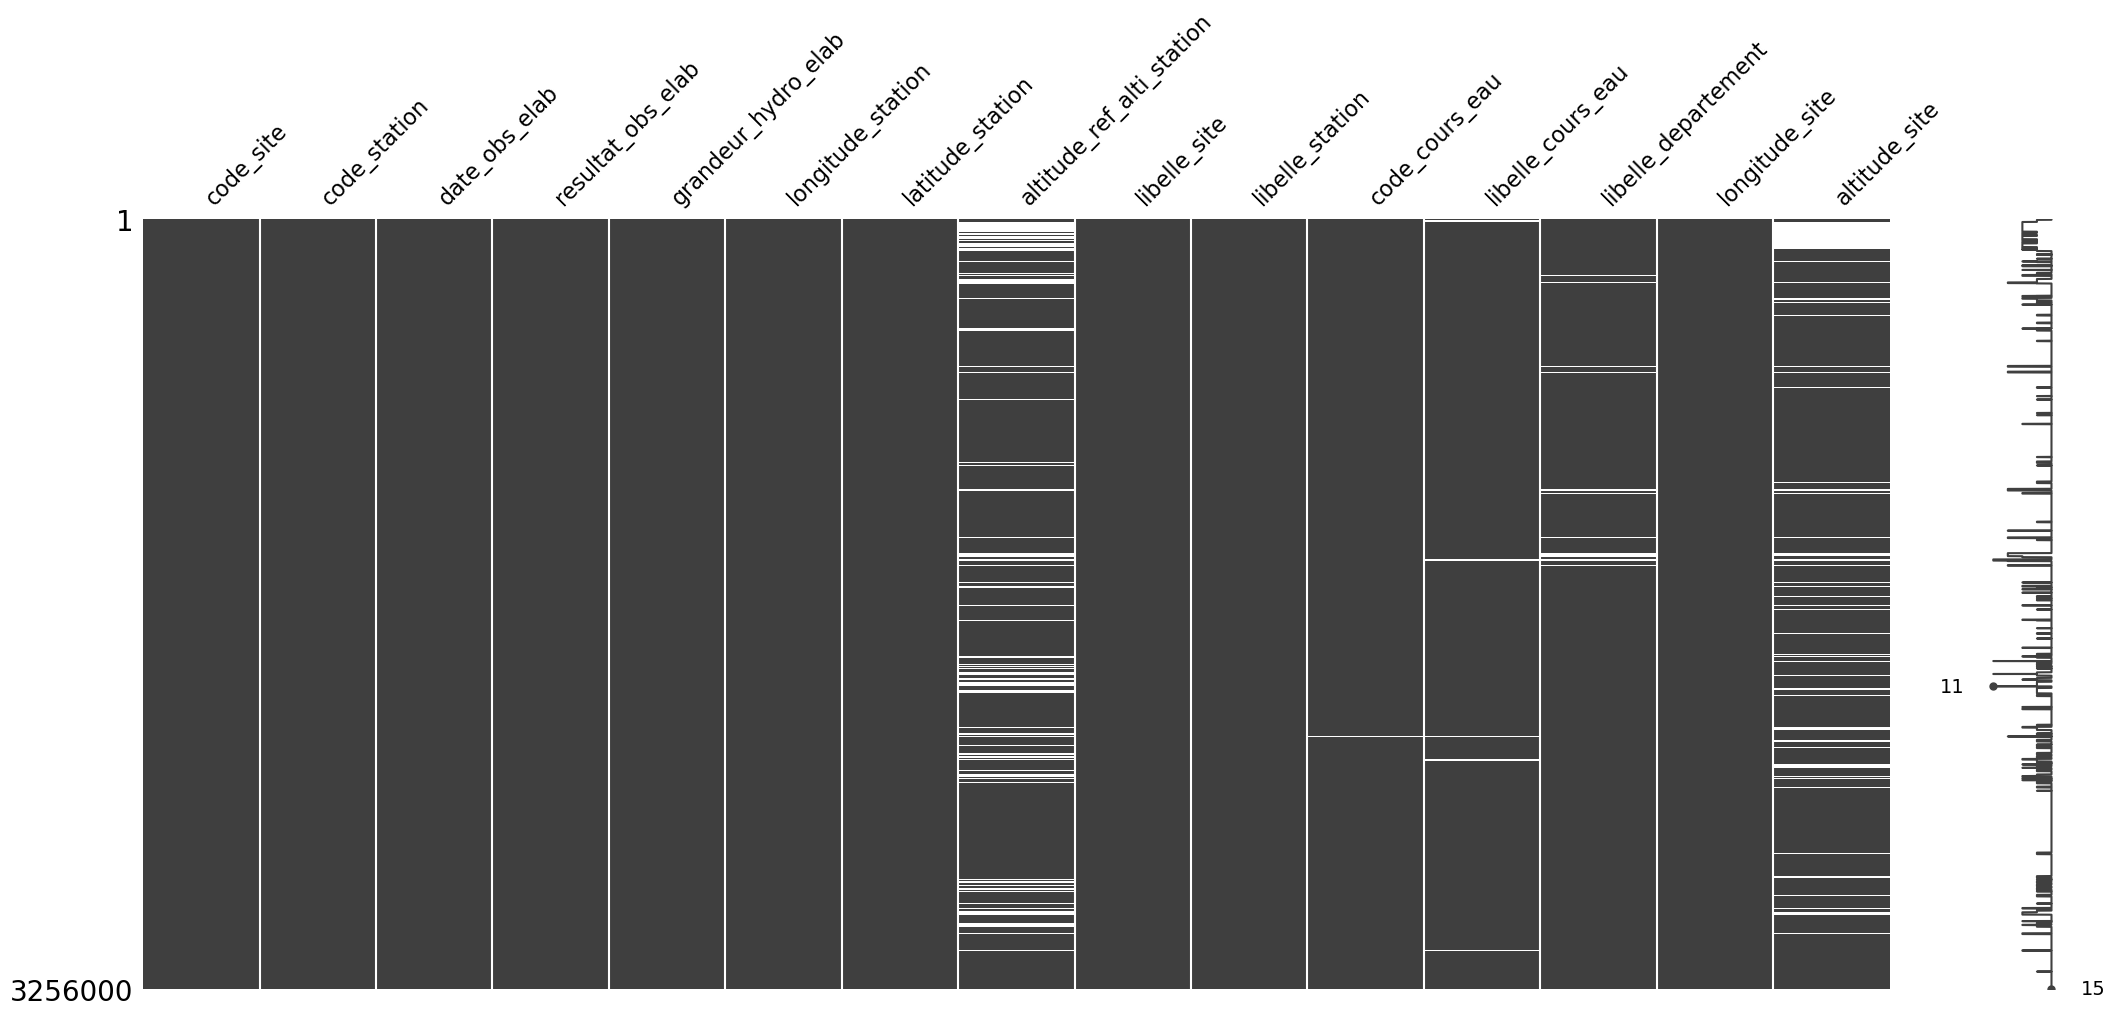

In [19]:
msno.matrix(base)

### 3.1.2) Description de la base

In [52]:
print(base.describe().T)
print(len(base))

                               count           mean            std  \
resultat_obs_elab          3256000.0   32687.970382  190357.363176   
longitude_station          3256000.0       1.506544      16.238911   
latitude_station           3256000.0      45.694519      11.880493   
altitude_ref_alti_station  2825382.0  147229.050166  111580.695629   
longitude_site             3254983.0       1.566145      16.335284   
altitude_site              2921167.0     205.210045    2273.034234   

                                    min           25%            50%  \
resultat_obs_elab         -2.885035e+06    474.000000    1599.000000   
longitude_station         -6.172518e+01      2.527185       4.292762   
latitude_station          -2.137662e+01     48.067078      48.648237   
altitude_ref_alti_station  0.000000e+00  49184.000000  143850.000000   
longitude_site            -6.172518e+01      2.526435       4.323845   
altitude_site              0.000000e+00     65.000000     150.000000   

    

# On test pour une station en particulier (station 1)

In [53]:
base["libelle_departement"].unique()

array(['GUADELOUPE', 'MARTINIQUE', 'MAYOTTE', 'LA REUNION', 'GUYANE', nan,
       'HAUT-RHIN', 'BAS-RHIN', 'VOSGES', 'MEURTHE-ET-MOSELLE', 'MOSELLE',
       'MEUSE', 'HAUTE-MARNE', 'ARDENNES', 'NORD', 'PAS-DE-CALAIS',
       'SOMME', "COTE-D'OR", 'AUBE', 'SEINE-ET-MARNE', 'YONNE', 'LOIRET',
       'ESSONNE', 'YVELINES', 'VAL-DE-MARNE', 'MARNE', 'AISNE',
       'SEINE-SAINT-DENIS', 'PARIS', 'SEINE-MARITIME', 'NIEVRE', 'OISE',
       "VAL-D'OISE", 'EURE', 'EURE-ET-LOIR'], dtype=object)

In [54]:
base[base["libelle_departement"].isin(["VAL-D'OISE", 'SEINE-SAINT-DENIS', 'VAL-DE-MARNE', "PARIS"])].groupby(["libelle_departement", "code_station"])["grandeur_hydro_elab"].count()

libelle_departement  code_station
PARIS                F700000102       181
                     F700000103      6470
SEINE-SAINT-DENIS    F664000104      6862
                     F664000106        87
VAL-D'OISE           H224000501      6862
                     H226000201      6862
                     H317061010      6750
VAL-DE-MARNE         F490000103        80
                     F490000104      6862
                     F664000404      1046
Name: grandeur_hydro_elab, dtype: int64

In [55]:
df=base[base["code_station"]=="F700000103"]

In [56]:
df.to_csv('./Data/station_paris.csv', index=False)